# IFQ619 - Assignment 2
## Insight Report


In [1]:
# Complete the following cell with your details and run to produce your personalised header for this assignment

from IPython.core.display import display, HTML

first_name = "Stephen"
last_name = "Whebell"
student_number = "n10924426"

personal_header = "<h1>"+first_name+" "+last_name+" ("+student_number+")</h1>"
display(HTML(personal_header))

---
## QUESTION 2

#### Question: 
What can the headlines from the Australian national broadcaster (the ABC) tell us about the concerns of the Australian public over time?

#### Data:
[A Million News Headlines](https://www.kaggle.com/therohk/million-headlines)


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.corpora.textcorpus import remove_stopwords
from gensim.summarization import keywords
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

from pattern.en import lemma

### 2.1 Question

The ABC is a publicly funded national broadcaster, which should (subject to some debate) represent current events and national concerns. <br>
Analysing the mention of terms over time, generating topics and mapping these topics over time should enable insight into the concerns of the Australian public as well as the consistency of reporting by the ABC.<br>

<br>
Key stakeholders in the outcomes of this analysis could include the ABC itself, other news reporting agencies seeking to compare trends as well as historians/anthropologists/commentators.

### 2.2 Data

In [3]:
# Import the data
headlines = pd.read_csv('data/abcnews-date-text.csv')

In [4]:
headlines.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
# Clean/prepare the data for analysis

# Split the date into separate year and month columns, drop the old date column
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['year'] = headlines['publish_date'].str[:4]
headlines['month'] = headlines['publish_date'].str[4:6]
headlines.drop('publish_date', axis=1, inplace=True)
headlines = headlines[['year', 'month', 'headline_text']]
headlines.rename(columns = {'headline_text' : 'text'}, inplace=True)

In [6]:
headlines.head()

,year,month,text
0,2003,02,aba decides against community broadcasting lic...
1,2003,02,act fire witnesses must be aware of defamation
2,2003,02,a g calls for infrastructure protection summit
3,2003,02,air nz staff in aust strike for pay rise
4,2003,02,air nz strike to affect australian travellers


We need to process the headlines into a format that useful data can be extracted from. This involves removing words that do not convey meaning (stop words), lemmatising words so that very similar words are not treated differently (e.g. Austrlian and Australians) and grouping together words that covey meaning together (bi/trigrams).

In [7]:
# Pre-process and remove stop words
processed = [remove_stopwords(simple_preprocess(headline, min_len = 3)) for headline in headlines['text']]

In [8]:
# Create bigrams and trigrams of words that occur together frequently e.g. 'general manager' etc
# General alone has different meaning to "General Manager"

# Build the bigram and trigram models
bigram = gensim.models.Phrases(processed)
trigram = gensim.models.Phrases(bigram[processed])

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
bigrams = [bigram_mod[terms] for terms in processed]

In [10]:
trigrams = [trigram_mod[terms] for terms in bigrams]

In [11]:
#Lemmatise the terms
try:
    lemma = [[lemma(wd) for wd in terms] for terms in trigrams] # This command never works the first time, despite multiple attempts at debugging
except:
    lemma = [[lemma(wd) for wd in terms] for terms in trigrams]

In [12]:
headlines['processed'] = lemma

In [13]:
headlines

,year,month,text,processed
0,2003,02,aba decides against community broadcasting lic...,"[aba, decide, community, broadcast, licence]"
1,2003,02,act fire witnesses must be aware of defamation,"[act, witness, aware, defamation]"
2,2003,02,a g calls for infrastructure protection summit,"[call, infrastructure, protection, summit]"
3,2003,02,air nz staff in aust strike for pay rise,"[air, staff, aust, strike_pay, rise]"
4,2003,02,air nz strike to affect australian travellers,"[air_strike, affect, australian, traveller]"
...,...,...,...,...
1186013,2019,12,vision of flames approaching corryong in victoria,"[vision, flame, approach, corryong, victoria]"
1186014,2019,12,wa police and government backflip on drug amne...,"[police, government, backflip, drug, amnesty, ..."
1186015,2019,12,we have fears for their safety: victorian premier,"[fear, safety, victorian_premier]"
1186016,2019,12,when do the 20s start,[start]


In [14]:
# Create a dataframe with the entire text of the headlines per year

yearly_grouped = headlines.groupby(['year'])['processed'].apply(list)

for year in yearly_grouped.index:
    flattened = [y for x in yearly_grouped[year] for y in x]
    yearly_grouped[year] = flattened
    
yearly = pd.DataFrame(index=yearly_grouped.index)
yearly['processed'] = yearly_grouped

yearly

,processed
year,
2003,"[aba, decide, community, broadcast, licence, a..."
2004,"[dead, bomb, end, aceh, new, year, concert, ab..."
2005,"[killed_kashmir, new, year, party, call, after..."
2006,"[adelaide, end_losing_streak, adelaide, notch_..."
2007,"[arrest, adelaide, new, year, govt, paper, fun..."
2008,"[deadliest_year, troops_iraq, french, cars_tor..."
2009,"[deadliest_year, force, afghanistan, dub, wet_..."
2010,"[degas, steal, museum, die, bangladesh, bus_cr..."
2011,"[kill, nigerian, market, blast, drown, egypt_b..."


### 2.3 Analysis


In [15]:
len(headlines) # Total number of headlines in the dataset

1186018

The number of headlines published each year changes, we should quantify this so we are able to use it in further analysis.

In [16]:
# Count how many headlines were published in each year

headperyearlist = []
for year in yearly.index:
    headperyearlist.append(len(headlines[(headlines['year'] == year)]))
yearly['total_headlines'] = headperyearlist

We can count the raw word frquency per year as a crude guide to change in public concern/issues over time.

In [17]:
# Count the most frequent words for each year
top_five_list = []

for year in yearly['processed']:
    word_counts = {}
    
    for word in year:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
            
    sorted_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1],reverse=True)}
    top_five = list(sorted_counts.keys())[0:5]
    top_five_list.append(top_five)

yearly['top_five_words'] = top_five_list

In [18]:
# Create vocab and BoW for the processed headlines to enable model fitting

vocab = Dictionary(headlines['processed'])

corpus = [vocab.doc2bow(terms) for terms in headlines['processed']] # Corpus of each individual headline

corpus_yearly = [vocab.doc2bow(terms) for terms in yearly['processed']] # Corpus of words used in each year

TF-IDF can be used to try and find the words which are most representative of each year when compared to the headlines as a whole.

In [19]:
# Use TF-IDF to determine the top 5 words for each year

tfidf_model = TfidfModel(corpus_yearly)

def get_tfidf(idx):
    term_values = [(vocab[el[0]],el[1]) for el in tfidf_model[corpus_yearly[idx]] if el[1]>0]
    srt =  sorted(term_values, key=lambda x: x[1],reverse=True)
    return list(map(lambda x: x[0],srt[:5]))

tfidf_words = []

for i in range(len(yearly)):
    tfidf_words.append(get_tfidf(i))

yearly['tfidf_words'] = tfidf_words

yearly

,processed,total_headlines,top_five_words,tfidf_words
year,,,,
2003,"[aba, decide, community, broadcast, licence, a...",63997,"[plan, new, police, govt, say]","[sar, sars_case, medical_indemnity, amrozi, so..."
2004,"[dead, bomb, end, aceh, new, year, concert, ab...",72674,"[plan, new, police, govt, council]","[najaf, fallujah, aristide, arafat, zarqawi]"
2005,"[killed_kashmir, new, year, party, call, after...",73124,"[plan, new, police, govt, council]","[telstra_sale, solon, vsu, wmc, korp]"
2006,"[adelaide, end_losing_streak, adelaide, notch_...",66901,"[plan, new, govt, police, say]","[kovco, closer_new, cole_inquiry, alkatiri, cl..."
2007,"[arrest, adelaide, new, year, govt, paper, fun...",77174,"[police, new, plan, govt, say]","[haneef, horse_flu, nrl_interview, closer_new,..."
2008,"[deadliest_year, troops_iraq, french, cars_tor...",79991,"[new, police, govt, plan, say]","[nrl_interview, wyd, fuelwatch, obama, haneef]"
2009,"[deadliest_year, force, afghanistan, dub, wet_...",76444,"[new, police, say, plan, govt]","[swine_flu, nrl_interview, swine_flu_case, et,..."
2010,"[degas, steal, museum, die, bangladesh, bus_cr...",74931,"[new, police, plan, council, say]","[session_summary, mining_tax, interview_ivan_h..."
2011,"[kill, nigerian, market, blast, drown, egypt_b...",77778,"[new, police, plan, flood, say]","[abc_entertainment, kohler_report, abc_sport, ..."


In [20]:
to_output = yearly[['total_headlines', 'top_five_words', 'tfidf_words']].copy()
to_output['top_five_words'] = [", ".join(x) for x in to_output['top_five_words']]
to_output['tfidf_words'] = [", ".join(x) for x in to_output['tfidf_words']]
to_output
to_output.to_csv('yearly.csv')

In [21]:
to_output

,total_headlines,top_five_words,tfidf_words
year,,,
2003,63997,"plan, new, police, govt, say","sar, sars_case, medical_indemnity, amrozi, sor..."
2004,72674,"plan, new, police, govt, council","najaf, fallujah, aristide, arafat, zarqawi"
2005,73124,"plan, new, police, govt, council","telstra_sale, solon, vsu, wmc, korp"
2006,66901,"plan, new, govt, police, say","kovco, closer_new, cole_inquiry, alkatiri, clo..."
2007,77174,"police, new, plan, govt, say","haneef, horse_flu, nrl_interview, closer_new, ..."
2008,79991,"new, police, govt, plan, say","nrl_interview, wyd, fuelwatch, obama, haneef"
2009,76444,"new, police, say, plan, govt","swine_flu, nrl_interview, swine_flu_case, et, ..."
2010,74931,"new, police, plan, council, say","session_summary, mining_tax, interview_ivan_he..."
2011,77778,"new, police, plan, flood, say","abc_entertainment, kohler_report, abc_sport, l..."


To gain a better understanding of how public concern changes over time we can attempt to derive topics from the headlines, classify each headline into its most likely topic and then assess to representation of each topic over time. <br>

LDA provides a good way to do this.<br>

To begin, we need to determine a sensible number of topics used to classify headlines. This is done by finding the number of topics which provides the best coherence score, but also a degree of personal choice and common sense.

In [22]:
%%time
# Calculate the U Mass coherence score for a range of different topic numbers to get an idea of the best number of topics
# Running this cell takes some time

coherence = []

for i in range(1,15,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=vocab, num_topics=i,
                             alpha='asymmetric',
                             chunksize = 15000, workers=23)
       
    cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence.append(cm.get_coherence())

Wall time: 6min 40s


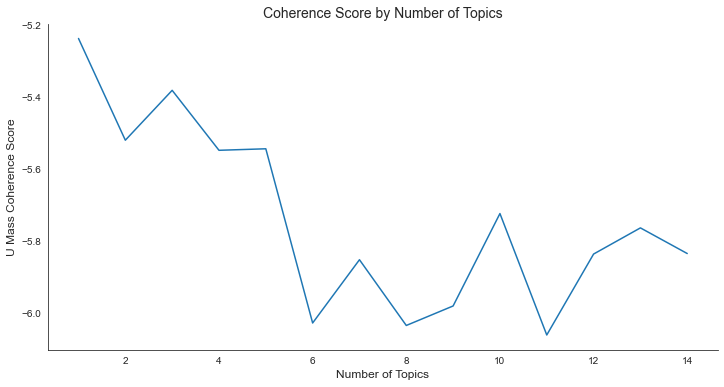

In [23]:
sns.set_style('white') # Seaborn for style

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(1,15,1), coherence)
ax.set_title('Coherence Score by Number of Topics', fontsize=14)
ax.set_ylabel('U Mass Coherence Score', fontsize=12)
ax.set_xlabel('Number of Topics', fontsize=12)
sns.despine()

There is decline in coherence after 2 topics - however, this is unlikely to represent the diversity of news headlines well. For this reason, we are going to choose 5 topics to model. This provides a good trade off between coherence score and the ability to represent the headlines accurately. (n.b. coherence score changes slightly with each model run - 5 topics was the best on most runs but may not appear as such in the graph run with the submitted notebook. This is also true of the exact topic words below.).

In [24]:
%%time
lda_model = LdaMulticore(corpus=corpus, id2word=vocab, num_topics=5,
                         alpha='asymmetric', eta='auto',
                         chunksize = 15000, passes = 4,
                         workers=23)

Wall time: 1min 30s


In [25]:
# view the topics in the model
for topic in lda_model.show_topics(num_topics=5,num_words=5):
    print("Topic "+str(topic[0])+"\n"+topic[1]+"\n")

Topic 0
0.008*"new" + 0.006*"plan" + 0.005*"police" + 0.004*"say" + 0.003*"man"

Topic 1
0.007*"say" + 0.006*"attack" + 0.006*"report" + 0.005*"new" + 0.004*"change"

Topic 2
0.006*"warn" + 0.006*"donald_trump" + 0.005*"return" + 0.005*"australia" + 0.004*"say"

Topic 3
0.013*"year" + 0.008*"nsw" + 0.007*"day" + 0.006*"end" + 0.006*"australia"

Topic 4
0.015*"australia" + 0.015*"police" + 0.006*"head" + 0.005*"final" + 0.005*"nsw"



We can predict the most likely topic for each headline and append it to the dataframe of all headlines.

In [26]:
%%time
# This cell takes come time to run

topics = []

for idx in range(len(headlines['processed'])):
    try:
        topics.append(lda_model.get_document_topics(corpus[idx], minimum_probability=0.3)[0][0])
    except:
        topics.append(np.nan)
        
headlines['topic'] = topics
topicdf = headlines[['year', 'topic']]

Wall time: 3min 58s


Some headlines were not able to have a topic predicted with a minimum probability of 30%.

In [27]:
nanpercent = np.round(topicdf['topic'].isnull().sum() / len(topicdf['topic']) * 100, decimals = 2)

print(str(nanpercent) + "% of headlines missing topic - dropping from dataframe.")

topicdf.dropna(how='any', axis=0, inplace=True)

0.03% of headlines missing topic - dropping from dataframe.


C:\Users\swheb\anaconda3\envs\ifq619\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


We can attempt to ascribe some interpretable meaning to the topics by using the words listed above and also by reviewing a sample of the headlines from each topic.

In [28]:
print("Random sample of 5 headlines from each topic: \n")
for i in range(5):
    sample = headlines.text[headlines['topic'] == i].sample(n=5).values
    print("Topic " + str(i) + ":")
    print(sample)

Random sample of 5 headlines from each topic: 

Topic 0:
['wa urged to take back paroled paedophile' 'pratt eliminated in sydney'
 'teen passenger avoids jail over fatal crash'
 'rio tinto decision hurts local businesses'
 'stirling to hear tio sale concerns']
Topic 1:
['mcginty promises funds to cut surgery waiting lists'
 'alcoa refinery spill prompts environmental' 'dairy live exports'
 'indian rat hole mine deaths in meghalaya get little attention'
 'lathams snipe project welcomes natures guardians of the future']
Topic 2:
['polls close in nsw election' 'kingsbury west papua bind'
 'alonso warned keep your armour on'
 'cassidy: another week; another failure of'
 'listen to the full interview with lex stone']
Topic 3:
['asset sales being rushed langbroek' 'open drum breast cancer'
 'bullying claims to be investigated further'
 'new delhi blasts not an accident' 'nt country hour 1506']
Topic 4:
['hazara migrants set up business in wa' 'gippsland soaks up october rain'
 'wine group to

In [29]:
# Split the topics out for each headline
topicdf = pd.concat([topicdf, pd.get_dummies(topicdf['topic'].astype('int'), prefix='topic')], axis=1)

In [30]:
topics = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']

Counting the number of each topic in a given year will enable us to track the prevalence of each over time.

In [31]:
summed_topics = topicdf.groupby('year')[topics].apply(sum)

yearly_topics = yearly.copy()

yearly_topics = pd.concat([yearly_topics, summed_topics], axis=1)

In [32]:
yearly_topics

,processed,total_headlines,top_five_words,tfidf_words,topic_0,topic_1,topic_2,topic_3,topic_4
year,,,,,,,,,
2003,"[aba, decide, community, broadcast, licence, a...",63997,"[plan, new, police, govt, say]","[sar, sars_case, medical_indemnity, amrozi, so...",37556,13323,6621,3528,2963
2004,"[dead, bomb, end, aceh, new, year, concert, ab...",72674,"[plan, new, police, govt, council]","[najaf, fallujah, aristide, arafat, zarqawi]",42498,15102,7606,4003,3458
2005,"[killed_kashmir, new, year, party, call, after...",73124,"[plan, new, police, govt, council]","[telstra_sale, solon, vsu, wmc, korp]",42922,15541,7505,3883,3269
2006,"[adelaide, end_losing_streak, adelaide, notch_...",66901,"[plan, new, govt, police, say]","[kovco, closer_new, cole_inquiry, alkatiri, cl...",39161,14295,6818,3518,3101
2007,"[arrest, adelaide, new, year, govt, paper, fun...",77174,"[police, new, plan, govt, say]","[haneef, horse_flu, nrl_interview, closer_new,...",45268,16713,7850,3947,3382
2008,"[deadliest_year, troops_iraq, french, cars_tor...",79991,"[new, police, govt, plan, say]","[nrl_interview, wyd, fuelwatch, obama, haneef]",47065,17403,8133,4160,3217
2009,"[deadliest_year, force, afghanistan, dub, wet_...",76444,"[new, police, say, plan, govt]","[swine_flu, nrl_interview, swine_flu_case, et,...",44113,16954,8104,4142,3125
2010,"[degas, steal, museum, die, bangladesh, bus_cr...",74931,"[new, police, plan, council, say]","[session_summary, mining_tax, interview_ivan_h...",42887,16817,8072,4087,3053
2011,"[kill, nigerian, market, blast, drown, egypt_b...",77778,"[new, police, plan, flood, say]","[abc_entertainment, kohler_report, abc_sport, ...",44336,16949,8403,4655,3417


### 2.4 Visualisation



<Figure size 432x288 with 0 Axes>

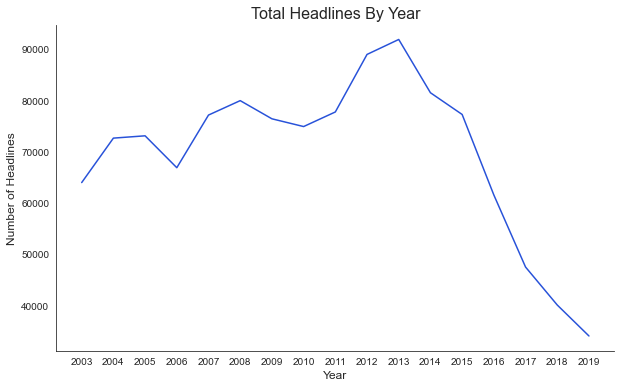

In [33]:
sns.set_style('white') # Seaborn for style
sns.set_palette('bright', desat=0.7)
plt.tight_layout()

fig,ax = plt.subplots(figsize=(10,6))

ax.plot(yearly['total_headlines'])
ax.set_title('Total Headlines By Year', fontsize=16)
ax.set_ylabel('Number of Headlines', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
sns.despine()

fig.savefig('headperyear.png')

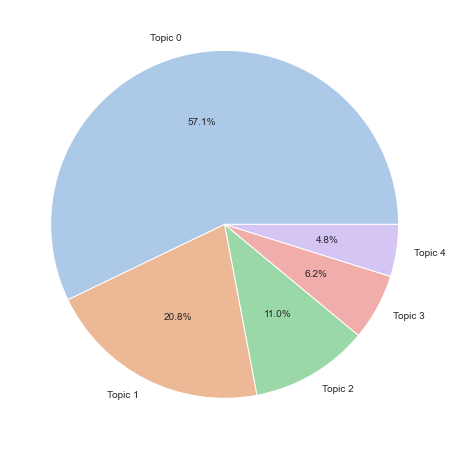

In [34]:
nicetopics = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']

sns.set_style('white') # Seaborn for style
sns.set_palette('pastel', desat=0.7)

fig,ax = plt.subplots(figsize=(8,8))

ax = plt.pie(yearly_topics[topics].sum(), labels=nicetopics, autopct='%1.1f%%')

fig.savefig('topicproportion.png')

We can plot the topics over time, but given the significant decrease in total headlines published over time we should index against this.

In [35]:
topicsindex = yearly_topics[topics].copy()

for i in topicsindex.columns:
    topicsindex[i] = topicsindex[i].div(yearly['total_headlines'])

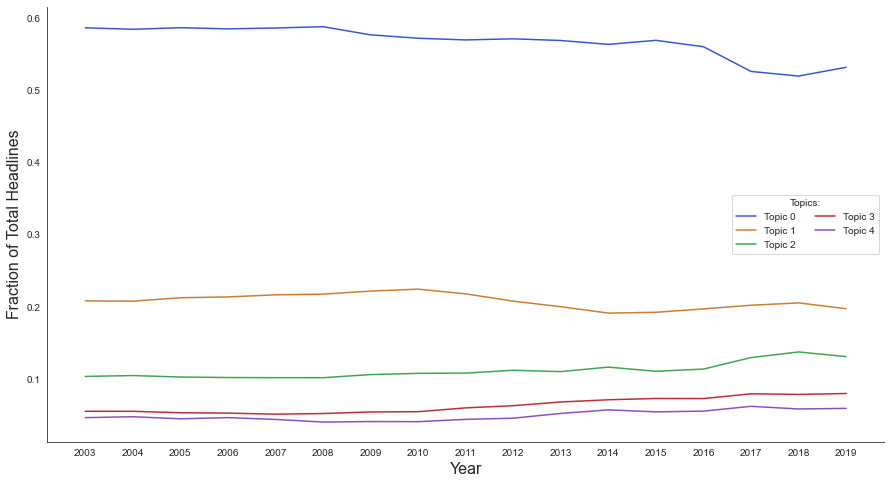

In [36]:
sns.set_style('white') # Seaborn for style
sns.set_palette('bright', desat=0.6)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(topicsindex)
#ax.set_title('Topics/Total Headlines by Year', fontsize=16)
ax.set_ylabel('Fraction of Total Headlines', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.legend(nicetopics, title='Topics:', ncol=2)
sns.despine()
plt.show()

fig.savefig('topictime.png')

### 2.5 Insight

- There was a significant decline in the number of headlines published over time
- Absolute word counts by year provides little insight into change over time as words that are used commonly occur in all years
- tf-idf words by year provide excellent insights into events and stoires that were unique to each year
- The generation of topics provides an avenue to track the consistency of reporting of the ABC over time
    - Lack of significant change likely represents consistentency of reporting